# Kuka

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### Start the Environment


Make sure that you're in the right virtual environment and the right python version.

In [1]:
!python --version
!pip install pybullet
!pip install tensorboardX

In [2]:
import matplotlib.pyplot as plt
import sys
from collections import deque
import timeit
from datetime import timedelta
from copy import deepcopy
import numpy as np
import random
from PIL import Image
from tensorboardX import SummaryWriter

import functools
import multiprocessing as mp
from multiprocessing import Pipe
from multiprocessing import Process
import signal
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim

from gym import spaces
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv  
import pybullet as p


current_dir=/home/monster/anaconda3/envs/python36/lib/python3.6/site-packages/pybullet_envs/bullet


In [3]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])
def worker(remote, env_fn):
    # Ignore CTRL+C in the worker process
    signal.signal(signal.SIGINT, signal.SIG_IGN)
    env = env_fn()
    try:
        while True:
            cmd, data = remote.recv()
            if cmd == 'step':
                ob, reward, done, info = env.step(data)
                remote.send((ob, reward, done, info))
            elif cmd == 'get_screen':
                screen = env._get_observation()
                screen = env._get_observation().transpose((2, 0, 1))
                screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
                screen = torch.from_numpy(screen)
                screen = resize(screen).unsqueeze(0)
                remote.send(screen)
            elif cmd == 'reset':
                ob = env.reset()
                remote.send(ob)
            elif cmd == 'close':
                remote.close()
                break
            elif cmd == 'get_spaces':
                remote.send((env.action_space, env.observation_space))
            else:
                raise NotImplementedError
    finally:
        env.close()

resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])
class MultiprocessVectorEnv:
    def __init__(self, env_fns):
        nenvs = len(env_fns)
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = \
            [Process(target=worker, args=(work_remote, env_fn))
             for (work_remote, env_fn) in zip(self.work_remotes, env_fns)]
        for p in self.ps:
            p.start()
        self.last_obs = [None] * self.num_envs
        self.remotes[0].send(('get_spaces', None))
        self.action_space, self.observation_space = self.remotes[0].recv()
        self.closed = False

    def __del__(self):
        if not self.closed:
            self.close()


    def step(self, actions):
        self._assert_not_closed()
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        results = [remote.recv() for remote in self.remotes]
        self.last_obs, rews, dones, infos = zip(*results)
        return self.last_obs, rews, dones, infos
    
    def get_screen(self):
        for remote in self.remotes:
            remote.send(('get_screen', None))
        results = [remote.recv() for remote in self.remotes]
        screens = torch.cat(results,dim=0)
        return screens

    def reset(self, mask=None):
        self._assert_not_closed()
        if mask is None:
            mask = np.zeros(self.num_envs)
        for m, remote in zip(mask, self.remotes):
            if not m:
                remote.send(('reset', None))

        obs = [remote.recv() if not m else o for m, remote,
               o in zip(mask, self.remotes, self.last_obs)]
        self.last_obs = obs
        return obs

    def close(self):
        self._assert_not_closed()
        self.closed = True
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()

    @property
    def num_envs(self):
        return len(self.remotes)

    def _assert_not_closed(self):
        assert not self.closed, "This env is already closed"

In [4]:
def make_env(idx, test):
    env = KukaDiverseObjectEnv(renders=False, isDiscrete=False, removeHeightHack=False, maxSteps=20)
    env.observation_space = spaces.Box(low=0., high=1., shape=(84, 84, 3), dtype=np.float32)
    env.action_space = spaces.Box(low=-1, high=1, shape=(5,1))
    return env

def make_batch_env(test):
    return MultiprocessVectorEnv(
        [functools.partial(make_env, idx, test)
            for idx in range(mp.cpu_count()*2)])

In [5]:
envs = make_batch_env(test=False)

In [6]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Actor-Critic implementation

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def build_hidden_layer(input_dim, hidden_layers):
    """Build hidden layer.
    Params
    ======
        input_dim (int): Dimension of hidden layer input
        hidden_layers (list(int)): Dimension of hidden layers
    """
    hidden = nn.ModuleList([nn.Linear(input_dim, hidden_layers[0])])
    if len(hidden_layers)>1:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        hidden.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
    return hidden

class ActorCritic(nn.Module):
    def __init__(self,state_size,action_size,shared_layers,
                 critic_hidden_layers=[],actor_hidden_layers=[],
                 seed=0, init_type=None):
        """Initialize parameters and build policy.
        Params
        ======
            state_size (int,int,int): Dimension of each state
            action_size (int): Dimension of each action
            shared_layers (list(int)): Dimension of the shared hidden layers
            critic_hidden_layers (list(int)): Dimension of the critic's hidden layers
            actor_hidden_layers (list(int)): Dimension of the actor's hidden layers
            seed (int): Random seed
            init_type (str): Initialization type
        """
        super(ActorCritic, self).__init__()
        self.init_type = init_type
        self.seed = torch.manual_seed(seed)
        self.sigma = nn.Parameter(torch.zeros(action_size))

        # Add shared hidden layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(state_size[0])))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(state_size[1])))
        linear_input_size = convh * convw * 32
        self.shared_layers = build_hidden_layer(input_dim=linear_input_size,
                                                hidden_layers=shared_layers)

        # Add critic layers
        if critic_hidden_layers:
            # Add hidden layers for critic net if critic_hidden_layers is not empty
            self.critic_hidden = build_hidden_layer(input_dim=shared_layers[-1],
                                                    hidden_layers=critic_hidden_layers)
            self.critic = nn.Linear(critic_hidden_layers[-1], 1)
        else:
            self.critic_hidden = None
            self.critic = nn.Linear(shared_layers[-1], 1)

        # Add actor layers
        if actor_hidden_layers:
            # Add hidden layers for actor net if actor_hidden_layers is not empty
            self.actor_hidden = build_hidden_layer(input_dim=shared_layers[-1],
                                                   hidden_layers=actor_hidden_layers)
            self.actor = nn.Linear(actor_hidden_layers[-1], action_size)
        else:
            self.actor_hidden = None
            self.actor = nn.Linear(shared_layers[-1], action_size)

        # Apply Tanh() to bound the actions
        self.tanh = nn.Tanh()

        # Initialize hidden and actor-critic layers
        if self.init_type is not None:
            self.shared_layers.apply(self._initialize)
            self.critic.apply(self._initialize)
            self.actor.apply(self._initialize)
            if self.critic_hidden is not None:
                self.critic_hidden.apply(self._initialize)
            if self.actor_hidden is not None:
                self.actor_hidden.apply(self._initialize)

    def _initialize(self, n):
        """Initialize network weights.
        """
        if isinstance(n, nn.Linear):
            if self.init_type=='xavier-uniform':
                nn.init.xavier_uniform_(n.weight.data)
            elif self.init_type=='xavier-normal':
                nn.init.xavier_normal_(n.weight.data)
            elif self.init_type=='kaiming-uniform':
                nn.init.kaiming_uniform_(n.weight.data)
            elif self.init_type=='kaiming-normal':
                nn.init.kaiming_normal_(n.weight.data)
            elif self.init_type=='orthogonal':
                nn.init.orthogonal_(n.weight.data)
            elif self.init_type=='uniform':
                nn.init.uniform_(n.weight.data)
            elif self.init_type=='normal':
                nn.init.normal_(n.weight.data)
            else:
                raise KeyError('initialization type is not found in the set of existing types')

    def forward(self, state):
        """Build a network that maps state -> (action, value)."""
        def apply_multi_layer(layers,x,f=F.leaky_relu):
            for layer in layers:
                x = f(layer(x))
            return x

        state = F.relu(self.bn1(self.conv1(state)))
        state = F.relu(self.bn2(self.conv2(state)))
        state = F.relu(self.bn3(self.conv3(state)))
        state = apply_multi_layer(self.shared_layers,state.view(state.size(0),-1))

        v_hid = state
        if self.critic_hidden is not None:
            v_hid = apply_multi_layer(self.critic_hidden,v_hid)

        a_hid = state
        if self.actor_hidden is not None:
            a_hid = apply_multi_layer(self.actor_hidden,a_hid)

        a = self.tanh(self.actor(a_hid))
        value = self.critic(v_hid).squeeze(-1)
        return a, value

Examine the state and action spaces.

Number of agents: 32
Size of each action: 5


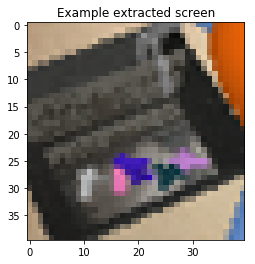

In [8]:
envs.reset()

# number of agents
num_agents = envs.num_envs
print('Number of agents:', num_agents)

init_screen = envs.get_screen().to(device)
_, _, screen_height, screen_width = init_screen.shape

# size of each action
action_size = envs.action_space.shape[0]
print('Size of each action:', action_size)

plt.figure()
plt.imshow(init_screen[0].cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [9]:
writer = SummaryWriter()
i_episode = 0
def collect_trajectories(envs, policy, tmax=200, nrand=5):
    
    global i_episode 
    global writer
    
    episode_rewards = 0
    
    
    def to_tensor(x, dtype=np.float32):
        return torch.from_numpy(np.array(x).astype(dtype)).to(device)
    
    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]
    value_list=[]
    done_list=[]

    state = envs.reset()

    # perform nrand random steps
    for _ in range(nrand):
        action = np.random.randn(num_agents, action_size)
        action = np.clip(action, -1.0, 1.0)
        _, reward, done, _   = envs.step(action)
        reward = torch.tensor(reward, device=device)
        

    for t in range(tmax):
        states = envs.get_screen().to(device)
        action_est, values = policy(states)
        sigma = nn.Parameter(torch.zeros(action_size))
        dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(device))
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        log_probs = torch.sum(log_probs, dim=-1).detach()
        values = values.detach()
        actions = actions.detach()
        
        env_actions = actions.cpu().numpy()
        _, reward, done, _  = envs.step(env_actions)
        rewards = to_tensor(reward)
        dones = to_tensor(done)

        state_list.append(states.unsqueeze(0))
        prob_list.append(log_probs.unsqueeze(0))
        action_list.append(actions.unsqueeze(0))
        reward_list.append(rewards.unsqueeze(0))
        value_list.append(values.unsqueeze(0))
        done_list.append(dones)

        if np.any(dones.cpu().numpy()):
            episode_rewards += rewards.sum(dim=0)
            i_episode += dones.sum(dim=0)
            writer.add_scalar('Episodes average rewards', episode_rewards.item()/dones.sum(dim=0).item(), i_episode.item())
            state = envs.reset()
            episode_rewards = 0
                
    state_list = torch.cat(state_list, dim=0)
    prob_list = torch.cat(prob_list, dim=0)
    action_list = torch.cat(action_list, dim=0)
    reward_list = torch.cat(reward_list, dim=0)
    value_list = torch.cat(value_list, dim=0)
    done_list = torch.cat(done_list, dim=0)
    return prob_list, state_list, action_list, reward_list, value_list, done_list

In [10]:
def calc_returns(rewards, values, dones):
    n_step = len(rewards)
    n_agent = len(rewards[0])

    # Create empty buffer
    GAE = torch.zeros(n_step,n_agent).float().to(device)
    returns = torch.zeros(n_step,n_agent).float().to(device)

    # Set start values
    GAE_current = torch.zeros(n_agent).float().to(device)

    TAU = 0.95
    discount = 0.99
    values_next = values[-1].detach()
    returns_current = values[-1].detach()
    for irow in reversed(range(n_step)):
        values_current = values[irow]
        rewards_current = rewards[irow]
        gamma = discount * (1. - dones[irow].float())

        # Calculate TD Error
        td_error = rewards_current + gamma * values_next - values_current
        # Update GAE, returns
        GAE_current = td_error + gamma * TAU * GAE_current
        returns_current = rewards_current + gamma * returns_current
        # Set GAE, returns to buffer
        GAE[irow] = GAE_current
        returns[irow] = returns_current

        values_next = values_current

    return GAE, returns


In [11]:
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    #env.render(mode='human')
    screen = env._get_observation().transpose((2, 0, 1))
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)
def eval_policy(envs, policy, tmax=1000):
    reward_list=[]
    state = envs.reset()
    for t in range(tmax):
        states = get_screen()
        action_est, values = policy(states)
        sigma = nn.Parameter(torch.zeros(action_size))
        dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(device))
        actions = dist.sample()
        _, reward, done, _  = envs.step(actions[0])
        dones = done
        reward_list.append(np.mean(reward))

        # stop if any of the trajectories is done to have retangular lists
        if np.any(dones):
            break
    return reward_list

## Network Architecture
An actor-critic structure with continuous action space is used for this project. The policy consists of 3 parts, a shared hidden layers, actor, and critic.
The actor layer outputs the mean value of a normal distribution, from which the agent's action is sampled. The critic layer yields the value function.

- Shared layer:
```
Input State(48,48,3) -> Conv2d(3, 16, 5, 2) -> BatchNorm2d(16) -> Conv2d(16, 32, 5, 2)-> BatchNorm2d(32)
-> Conv2d(32, 32, 5, 2) -> BatchNorm2d(32) -> Dense(128) -> LeakyReLU -> Dense(128) -> LeakyReLU -> Dense(64) -> LeakyReLU
```
- Actor and Critic layers:
```
LeakyRelu -> Dense(64) -> LeakyRelu -> Dense(4)-> tanh -> Actor's output
LeakyReLU -> Dense(64) -> LeakyRelu -> Dense(1) -> Critic's output
```

### Model update using PPO/GAE
The hyperparameters used during training are:

Parameter | Value | Description
------------ | ------------- | -------------
Number of Agents | 1 | Number of agents trained simultaneously
tmax | 20 | Maximum number of steps per episode
Epochs | 10 | Number of training epoch per batch sampling
Batch size | 128 | Size of batch taken from the accumulated  trajectories
Discount (gamma) | 0.993 | Discount rate 
Epsilon | 0.07 | Ratio used to clip r = new_probs/old_probs during training
Gradient clip | 10.0 | Maximum gradient norm 
Beta | 0.01 | Entropy coefficient 
Tau | 0.95 | tau coefficient in GAE
Learning rate | 2e-4 | Learning rate 
Optimizer | Adam | Optimization method


In [12]:
# run your own policy!
policy=ActorCritic(state_size=(screen_height, screen_width),
              action_size=action_size,
              shared_layers=[128, 64],
              critic_hidden_layers=[64],
              actor_hidden_layers=[64],
              init_type='xavier-uniform',
              seed=0).to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
optimizer = optim.Adam(policy.parameters(), lr=2e-4)

In [13]:
PATH = 'policy_ppo.pt'

In [14]:
best_mean_reward = None

scores_window = deque(maxlen=100)  # last 100 scores

discount = 0.993
epsilon = 0.07
beta = .01
opt_epoch = 10
season = 1000000
batch_size = 128
tmax = 1000//num_agents#env episode steps
save_scores = []
start_time = timeit.default_timer()

for s in range(season):
    policy.eval()
    old_probs_lst, states_lst, actions_lst, rewards_lst, values_lst, dones_list = collect_trajectories(envs=envs,
                                                                                                       policy=policy,
                                                                                                       tmax=tmax,
                                                                                                       nrand = 5)

    season_score = rewards_lst.sum(dim=0).sum().item()
    scores_window.append(season_score)
    save_scores.append(season_score)
    
    gea, target_value = calc_returns(rewards = rewards_lst,
                                     values = values_lst,
                                     dones=dones_list)
    gea = (gea - gea.mean()) / (gea.std() + 1e-8)

    policy.train()

    # cat all agents
    def concat_all(v):
        #print(v.shape)
        if len(v.shape) == 3:#actions
            return v.reshape([-1, v.shape[-1]])
        if len(v.shape) == 5:#states
            v = v.reshape([-1, v.shape[-3], v.shape[-2],v.shape[-1]])
            #print(v.shape)
            return v
        return v.reshape([-1])

    old_probs_lst = concat_all(old_probs_lst)
    states_lst = concat_all(states_lst)
    actions_lst = concat_all(actions_lst)
    rewards_lst = concat_all(rewards_lst)
    values_lst = concat_all(values_lst)
    gea = concat_all(gea)
    target_value = concat_all(target_value)
    
    # gradient ascent step
    n_sample = len(old_probs_lst)//batch_size
    idx = np.arange(len(old_probs_lst))
    np.random.shuffle(idx)
    for epoch in range(opt_epoch):
        for b in range(n_sample):
            ind = idx[b*batch_size:(b+1)*batch_size]
            g = gea[ind]
            tv = target_value[ind]
            actions = actions_lst[ind]
            old_probs = old_probs_lst[ind]

            action_est, values = policy(states_lst[ind])
            sigma = nn.Parameter(torch.zeros(action_size))
            dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(device))
            log_probs = dist.log_prob(actions)
            log_probs = torch.sum(log_probs, dim=-1)
            entropy = torch.sum(dist.entropy(), dim=-1)

            ratio = torch.exp(log_probs - old_probs)
            ratio_clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
            L_CLIP = torch.mean(torch.min(ratio*g, ratio_clipped*g))
            # entropy bonus
            S = entropy.mean()
            # squared-error value function loss
            L_VF = 0.5 * (tv - values).pow(2).mean()
            # clipped surrogate
            L = -(L_CLIP - L_VF + beta*S)
            optimizer.zero_grad()
            # This may need retain_graph=True on the backward pass
            # as pytorch automatically frees the computational graph after
            # the backward pass to save memory
            # Without this, the chain of derivative may get lost
            L.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(policy.parameters(), 10.0)
            optimizer.step()
            del(L)

    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.998

    mean_reward = np.mean(scores_window)
    writer.add_scalar("epsilon", epsilon, s)
    writer.add_scalar("beta", beta, s)
    writer.add_scalar("Score", mean_reward, s)
    # display some progress every n iterations
    if best_mean_reward is None or best_mean_reward < mean_reward:
                # For saving the model and possibly resuming training
                torch.save({
                        'policy_state_dict': policy.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epsilon': epsilon,
                        'beta': beta
                        }, PATH)
                if best_mean_reward is not None:
                    print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
                best_mean_reward = mean_reward
    if s>=25 and mean_reward>50:
        print('Environment solved in {:d} seasons!\tAverage Score: {:.2f}'.format(s+1, mean_reward))
        break


print('Average Score: {:.2f}'.format(mean_reward))
elapsed = timeit.default_timer() - start_time
print("Elapsed time: {}".format(timedelta(seconds=elapsed)))
writer.close()
envs.close()

Best mean reward updated 30.000 -> 32.500, model saved
Best mean reward updated 32.500 -> 38.000, model saved
Best mean reward updated 38.000 -> 39.000, model saved
Best mean reward updated 39.000 -> 39.200, model saved
Best mean reward updated 39.200 -> 39.600, model saved
Best mean reward updated 39.600 -> 40.182, model saved
Best mean reward updated 40.182 -> 40.250, model saved
Best mean reward updated 40.250 -> 40.286, model saved
Best mean reward updated 40.286 -> 40.733, model saved
Best mean reward updated 40.733 -> 41.438, model saved
Best mean reward updated 41.438 -> 41.824, model saved
Best mean reward updated 41.824 -> 42.389, model saved
Best mean reward updated 42.389 -> 43.000, model saved
Best mean reward updated 43.000 -> 43.300, model saved
Best mean reward updated 43.300 -> 44.143, model saved
Best mean reward updated 44.143 -> 44.304, model saved
Best mean reward updated 44.304 -> 44.667, model saved
Best mean reward updated 44.667 -> 44.760, model saved
Best mean 

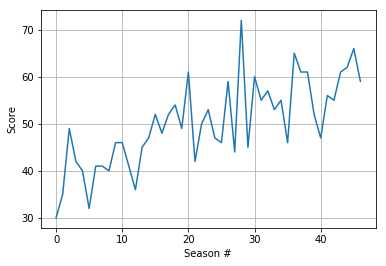

In [15]:
fig = plt.figure()
plt.plot(np.arange(len(save_scores)), save_scores)
plt.ylabel('Score')
plt.xlabel('Season #')
plt.grid()
plt.show()

## Evaluation

In [16]:
episode = 10
scores_window = deque(maxlen=100)  # last 100 scores
env = KukaDiverseObjectEnv(renders=False, isDiscrete=False, removeHeightHack=False, maxSteps=20, isTest=True)
env.cid = p.connect(p.DIRECT)
# load the model
checkpoint = torch.load(PATH)
policy.load_state_dict(checkpoint['policy_state_dict'])

# evaluate the model
for e in range(episode):
    rewards = eval_policy(envs=env, policy=policy)
    reward = np.sum(rewards,0)
    print("Episode: {0:d}, reward: {1}".format(e+1, reward), end="\n")

Episode: 1, reward: 1.0
Episode: 2, reward: 1.0
Episode: 3, reward: 0.0
Episode: 4, reward: 0.0
Episode: 5, reward: 1.0
Episode: 6, reward: 0.0
Episode: 7, reward: 1.0
Episode: 8, reward: 1.0
Episode: 9, reward: 0.0
Episode: 10, reward: 0.0
